# Exercise 5

### Necessary imports

In [171]:
import pandas as pd
from nltk.corpus import stopwords
from nltk import pos_tag
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim import corpora
from gensim.models import CoherenceModel
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
warnings.filterwarnings("ignore")
from datasets import load_dataset
import spacy

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

stop_words = stopwords.words('english')
plt.style.use('dark_background')

### Dataset loading

In [176]:
dataset = load_dataset("okite97/news-data")
df = pd.DataFrame(dataset['train'])

Found cached dataset csv (C:/Users/lores/.cache/huggingface/datasets/okite97___csv/okite97--news-data-15d8f79c697f14ed/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/2 [00:00<?, ?it/s]

### Pre-processing of dataset

In [198]:
def preprocess(sentence):
    # Maintain only content words (nouns, verbs, adjectives, adverbs) of the sentence with minimum length of 4 characters, remove stopwords and punctuation
    sentence = nlp(sentence)
    sentence = [token.lemma_ for token in sentence if token.pos_ in ['NOUN'] and len(token) > 3 and token.lemma_ not in stop_words and not token.is_punct]
    return sentence

In [199]:
df['text_cleaned'] = df['Excerpt'].apply(preprocess)

In [200]:
# Tokenize the texts
texts = df['text_cleaned']

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

## First Method: LDA for topic modeling

### Hyperparameter tuning

In [201]:
def calculate_coherence_score_lda(n):
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# List containing various hyperparameters
no_of_topics = [2, 3, 4, 5, 6, 7, 8, 9, 10]

best_coherence_score = 0
best_n = 0

for n in no_of_topics:
    coherence_score = calculate_coherence_score_lda(n)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_n = n
    print(f"Number of Topics: {n}")
    print(f"Coherence Score: {coherence_score}")
    print("-------------------------------------")

Number of Topics: 2
Coherence Score: 0.39566714905992784
-------------------------------------
Number of Topics: 3
Coherence Score: 0.4465463487698819
-------------------------------------
Number of Topics: 4
Coherence Score: 0.488300306655651
-------------------------------------
Number of Topics: 5
Coherence Score: 0.5090984396271991
-------------------------------------
Number of Topics: 6
Coherence Score: 0.5345540724578987
-------------------------------------
Number of Topics: 7
Coherence Score: 0.5488976412460312
-------------------------------------
Number of Topics: 8
Coherence Score: 0.5455005586548345
-------------------------------------
Number of Topics: 9
Coherence Score: 0.5626183633043306
-------------------------------------
Number of Topics: 10
Coherence Score: 0.5857811807534548
-------------------------------------


### Visualizing the topics with pyLDAvis

In [202]:
# Best model
best_lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=best_n,
                     random_state=42)
                        
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.147617  0.038527       1        1  12.582638
2     -0.006574  0.138480       2        1  10.575574
5      0.063905 -0.068665       3        1  10.138972
9     -0.092153 -0.034465       4        1  10.009845
0      0.045851 -0.084484       5        1  10.002678
7     -0.066083 -0.095303       6        1   9.937894
4      0.019698 -0.021554       7        1   9.483095
6     -0.024429 -0.084857       8        1   9.428668
8      0.225756  0.031273       9        1   9.150479
1     -0.018354  0.181049      10        1   8.690156, topic_info=           Term        Freq       Total Category  logprob  loglift
15      country  250.000000  250.000000  Default  30.0000  30.0000
82     election  125.000000  125.000000  Default  29.0000  29.0000
113    champion   65.000000   65.000000  Default  28.0000  28.0000
32    president   62.000000   62.000000  Default  27.0000  27.0000
61          day   57.000000   57.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
71         star   10.259334   72.295443  Topic10  -4.9171   0.4904
112       world   11.007151  147.350755  Topic10  -4.8468  -0.1513
46   government   11.410488  255.896853  Topic10  -4.8108  -0.6673
20         club    9.894936   60.820180  Topic10  -4.9533   0.6271
202     vaccine    9.845303  157.035926  Topic10  -4.9583  -0.3265

[603 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1719      6  0.845609   -range
581       2  0.940961    abuse
240       1  0.042164  account
240       4  0.801121  account
240       7  0.042164  account
...     ...       ...      ...
17        7  0.119264     year
17        8  0.042935     year
17        9  0.152658     year
17       10  0.200364     year
1878      6  0.938933   zoning

[1342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 10, 1, 8, 5, 7, 9, 2])

### Create Cloud Words for each topic

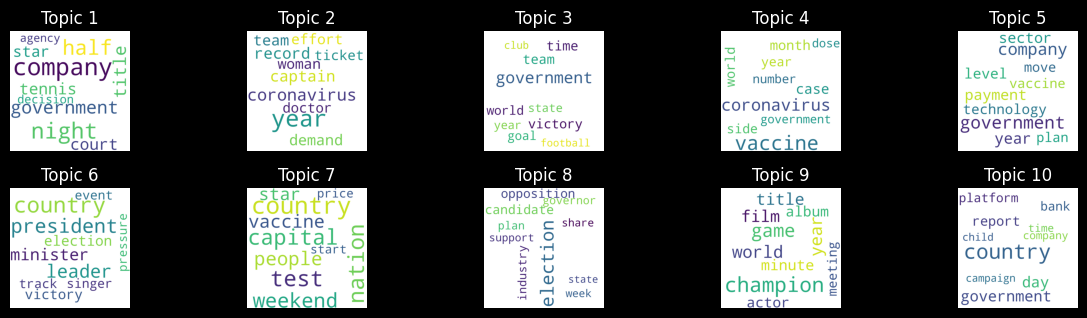

In [203]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(best_n):
    words = best_lda_model.show_topics()[i][1].split('+')
    top_terms_key = {}
    for term in words:
        word = term.split('*')[1].replace('"', '')
        freq = term.split('*')[0]
        top_terms_key[word] = float(freq)
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(top_terms_key)
    plt.subplot(int(best_n / 2) if int(best_n % 2 == 0) else int(best_n / 2) + 1, int(best_n / 2) if int(best_n % 2 == 0) else int(best_n / 2) + 1, i+1)
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.imshow(wc)

## Second Method: LSA for topic modeling

### Creating the corpus and dictionary

In [204]:
# Tokenize the text with NLTK
texts = df['text_cleaned']

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

### Hyperparameter tuning for LSA

In [205]:
def calculate_coherence_score_lsi(n):
    lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=n, random_seed=42)
    coherence_model_lsi = CoherenceModel(model=lsi_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()
    return coherence_lsi

# List containing various hyperparameters
no_of_topics = [2, 3, 4, 5, 6, 7, 8, 9, 10]

best_coherence_score = 0
best_n = 0

for n in no_of_topics:
    coherence_score = calculate_coherence_score_lsi(n)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_n = n
    print(f"Number of Topics: {n}")
    print(f"Coherence Score: {coherence_score}")
    print("-------------------------------------")

Number of Topics: 2
Coherence Score: 0.3523685359127586
-------------------------------------
Number of Topics: 3
Coherence Score: 0.41120717222250996
-------------------------------------
Number of Topics: 4
Coherence Score: 0.4356461994457903
-------------------------------------
Number of Topics: 5
Coherence Score: 0.41875293275968384
-------------------------------------
Number of Topics: 6
Coherence Score: 0.45300368917927414
-------------------------------------
Number of Topics: 7
Coherence Score: 0.47616336452480024
-------------------------------------
Number of Topics: 8
Coherence Score: 0.4503709339828863
-------------------------------------
Number of Topics: 9
Coherence Score: 0.43752018723518643
-------------------------------------
Number of Topics: 10
Coherence Score: 0.5026722410293626
-------------------------------------


### Creating the WordClouds for each topic

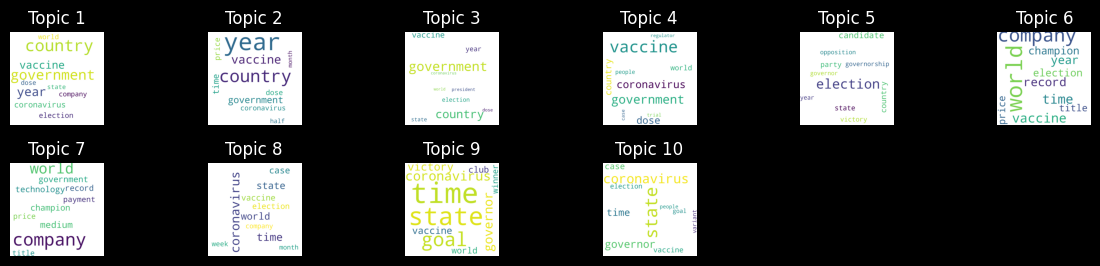

In [206]:
import numpy as np

best_lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=best_n, random_seed=42)

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(best_n):
    words = best_lsi_model.show_topics()[i][1].split('+')
    top_terms_key = {}
    for term in words:
        word = term.split('*')[1].replace('"', '')
        freq = abs(float(term.split('*')[0]))
        top_terms_key[word] = float(freq)

    norm_1 = np.abs([val for val in top_terms_key.values()]).sum(axis=0)
    normalized_top_terms_key = {key:top_terms_key[key]/norm_1 for key in top_terms_key.keys()}
    
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(normalized_top_terms_key)
    plt.subplot(int(best_n / 2) + 1, int(best_n / 2) + 1, i+1)
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.imshow(wc)